In [ ]:
# for cloud use
!pip install matplotlib pylatexenc qiskit==2.0.2 qiskit-aer
!wget https://raw.githubusercontent.com/Dpbm/qnqueens/refs/heads/main/utils.py

In [23]:
from typing import List
from collections import defaultdict
from itertools import product
import json

from qiskit import QuantumCircuit
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2, SamplerV2

from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

from utils import Mapping, get_attacks_for_each_cell, get_pos_mapping

In [24]:
def solution_board(bit_string:str, n:int):
    """
    params:
        bit_string:str
        n:int - board side

    Draw Solution board based on a bit string
    """

    matrix = []

    qubit = 0
    for i in range(n):
        matrix.append([])
        for j in range(n):
            matrix[-1].append(int(bit_string[qubit]))
            qubit += 1
    
    plt.pcolormesh(matrix,edgecolors="k",linewidth=2)
    plt.title("Solution board. Bit string=%s"%(bit_string))
    plt.axis('off')
    plt.savefig("solution-board-qaoa-%s.png"%(bit_string), bbox_inches="tight")
    plt.show()

In [3]:
def get_obs(total_qubits:int, qubits:List[int]) -> str:
    """
    params:
        total_qubits:int
        qubits:List[int] - the qubits to apply a Z observable

    Generate an observable string.
    """

    obs = ['I']*total_qubits

    for qubit in qubits:
        obs[-(qubit+1)] = 'Z'

    return ''.join(obs)

In [25]:
def cost_func(
    params:List[float], 
    ansatz:QuantumCircuit, 
    hamiltonian:SparsePauliOp, 
    estimator:EstimatorV2, 
    history:List[float]
    ) -> float:

    """
    params:
        params: List[float] - the angles for the circuit
        ansatz : QuantumCircuit - the circuit itself
        hamiltonian: SparsePauliOp - the hamiltonian to be evaluated
        estimator: EstimatorV2 - the estimator object to evaluate the hamiltonian
        history: List[float] - an outside object that holds the history of costs

    Get the cost of the current circuit.
    """

    isa_h = hamiltonian.apply_layout(ansatz.layout)
    job = estimator.run([(ansatz, isa_h, params)])

    results = job.result()[0]

    # once we want our cost to be zero, we may get the absolute value
    cost = abs(results.data.evs)

    history.append(cost)
    print("Current cost: ", cost, "; params: ", params)

    return cost

In [26]:
def get_H(mapping:Mapping, P:int, n:int) -> SparsePauliOp:
    """
    params:
        mapping: Mapping - The qubits mapping
        P: int - The Lagrange term for penality
        n: int - The side of the board

    Generates the hamiltonian
    """

    total_qubits = n*n
    terms = defaultdict(float)

    constant_obs = get_obs(total_qubits, []) 

    # first part - adding the quadratic terms
    term_coeff = 0.25
    for i in range(n):
        for j in range(n):
            pos = (i,j) # (row, column)
            current_pos_qubit = mapping[pos]

            attacks = get_attacks_for_each_cell(pos, n)

            for attack in attacks:
                attack_qubit = mapping[attack]
                
                attack_obs = get_obs(total_qubits, [current_pos_qubit, attack_qubit])
                ind_1_obs = get_obs(total_qubits, [current_pos_qubit])
                ind_2_obs = get_obs(total_qubits, [attack_qubit])

                #terms[constant_obs] += term_coeff
                terms[attack_obs] += term_coeff
                terms[ind_1_obs] += term_coeff
                terms[ind_2_obs] += term_coeff

    """
    Once the penality terms are giving in the form:

    P(sum{i -> N^2}((1+zi)/2) - N)^2 = 0

    we have:

    P(sum{i -> N^2}(1/2 + zi/2) - N)^2 = 0
    P(sum{i -> N^2}(1/2) + sum{i -> N^2}(1/2 zi) - N)^2 = 0
    P(N^2 1/2 + 1/2 sum{i -> N^2}(zi) - N)^2 = 0
    P(1/2 sum{i -> N^2}(zi) - N 2/2 + N^2 1/2)^2 = 0
    P(1/2 sum{i -> N^2}(zi) + 1/2 (N^2 - 2N))^2 = 0
    P(1/2 sum{i -> N^2}(zi) + 1/2 (N^2 - 2N))(1/2 sum{i -> N^2}(zi) + 1/2 (N^2 - 2N)) = 0
    P( (1/2 sum{i -> N^2}(zi))^2 + 2((N^2 - 2N)(1/2 sum{i -> N^2}(zi))) + (1/2 (N^2 - 2N))^2 ) = 0

    we could rewrite as:

    A = (1/2 sum{i -> N^2}(zi))^2
    B =  2((N^2 - 2N)(1/2 sum{i -> N^2}(zi)))
    C = (1/2 (N^2 - 2N))^2

    so, the final equation is: 
    
    P(A+B+C) = 0


    ---------------------------------

    To understand better the A term lets break it down:

    (1/2 (z0 + z1 + z2 + ... + z(N^2)))(1/2 (z0 + z1 + z2 + ... + z(N^2)))
    1/4 (z0^2 + z0z1 + z0z2 + .... + z(N^2)^2)
    """

    # A term
    penality_terms = list(range(total_qubits))
    penality_constant = P * 0.25
    for x0,x1 in product(penality_terms, penality_terms):
        obs = get_obs(total_qubits, [x0] if x0 == x1 else [x0, x1])
        terms[obs] += penality_constant

    # B term
    constant_for_b = P * 2 * 0.5 * (total_qubits - (2*n))
    for qubit in range(total_qubits):
        obs = get_obs(total_qubits, [qubit])
        terms[obs] += constant_for_b
    
    
    # once C is a constant we gonna discard it
    # constant_C = (0.5 * (total_qubits - (2*n))) ** 2
    #terms[constant_obs] += P*constant_C


    return SparsePauliOp.from_list(terms.items())
    

In [27]:
N = 4
mapping = get_pos_mapping(N)
hamiltonian = get_H(mapping, N*N, N)
hamiltonian

SparsePauliOp(['IIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIZI', 'IIIIIIIIIIIZIIIZ', 'IIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIZIZ', 'IIIIIIIIIIIIIZII', 'IIIIIIIZIIIIIIIZ', 'IIIIIIIZIIIIIIII', 'IIIIIIIIIIIIZIIZ', 'IIIIIIIIIIIIZIII', 'IIIZIIIIIIIIIIIZ', 'IIIZIIIIIIIIIIII', 'IIIIIIIIIIZIIIIZ', 'IIIIIIIIIIZIIIII', 'IIIIIZIIIIIIIIIZ', 'IIIIIZIIIIIIIIII', 'ZIIIIIIIIIIIIIIZ', 'ZIIIIIIIIIIIIIII', 'IIIIIIIIIIZIIIZI', 'IIIIIIIIIIIIIZZI', 'IIIIIIZIIIIIIIZI', 'IIIIIIZIIIIIIIII', 'IIIIIIIIIIIIZIZI', 'IIZIIIIIIIIIIIZI', 'IIZIIIIIIIIIIIII', 'IIIIIIIIIZIIIIZI', 'IIIIIIIIIZIIIIII', 'IIIIZIIIIIIIIIZI', 'IIIIZIIIIIIIIIII', 'IIIIIIIIIIIZIIZI', 'IIIIIIIIIZIIIZII', 'IIIIIZIIIIIIIZII', 'IIIIIIIIIIIIZZII', 'IZIIIIIIIIIIIZII', 'IZIIIIIIIIIIIIII', 'IIIIIIIIZIIIIZII', 'IIIIIIIIZIIIIIII', 'IIIIIIIIIIZIIZII', 'IIIIIIIZIIIIIZII', 'IIIIIIIIZIIIZIII', 'IIIIZIIIIIIIZIII', 'ZIIIIIIIIIIIZIII', 'IIIIIIIIIZIIZIII', 'IIIIIIZIIIIIZIII', 'IIIZIIIIIIIIZIII', 'IIIIIIIIIIZZIIII', 'IIIIIIIIIZIZIIII', 'IIIIIIIZIIIZIIII', 'IIII

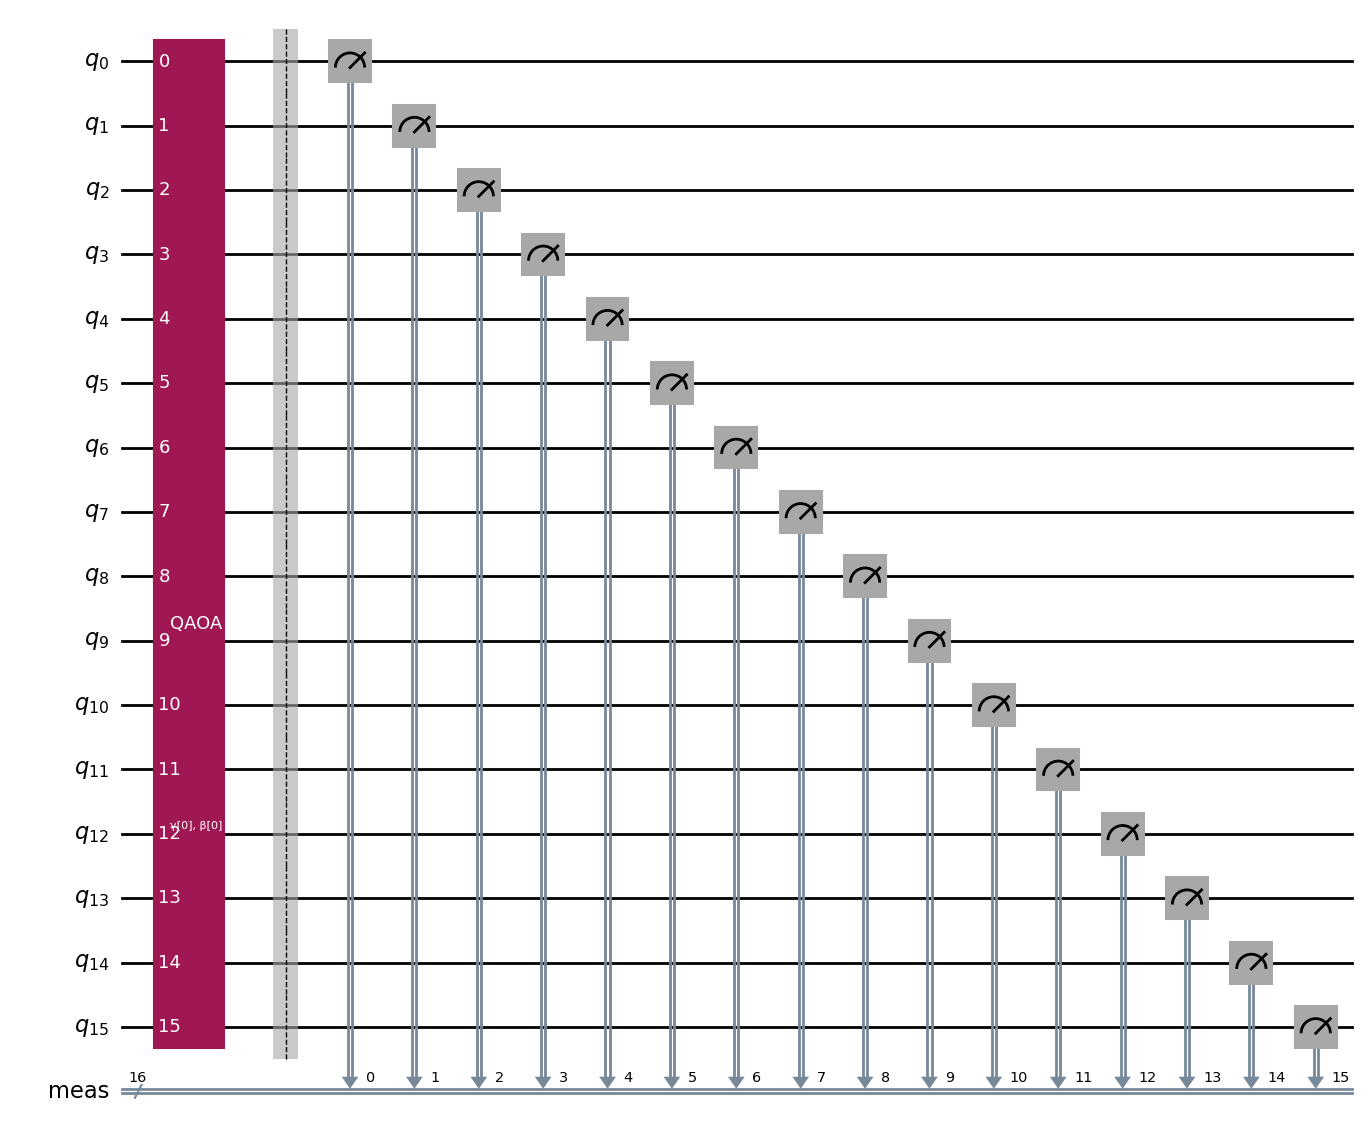

In [28]:
qaoa = QAOAAnsatz(cost_operator=hamiltonian, reps=1)
qaoa.measure_all()
qaoa.draw('mpl')

In [29]:
pi_or_two_pi = lambda i : (int(i%2==0)+1)*np.pi

In [30]:
sim = AerSimulator()
pm = generate_preset_pass_manager(optimization_level=0, backend=sim)
isa_qc = pm.run(qaoa)

total_params = len(isa_qc.parameters)

history = []
estimator = EstimatorV2()
init_params = [np.random.uniform(low=0.0, high=pi_or_two_pi(i), size=1)[0] for i in range(total_params)]

print("Initial Parameters: ", init_params)

result = minimize(
        cost_func,
        init_params,
        args=(isa_qc, hamiltonian, estimator, history),
        method="COBYLA",
        bounds=[ (0,pi_or_two_pi(i)) for i in range(total_params) ],
        tol=1e-3,
    )

Initial Parameters:  [np.float64(0.41423870939380697), np.float64(0.6931546393494428)]
Current cost:  55.470703125 ; params:  [0.41423871 0.69315464]
Current cost:  26.675781250000004 ; params:  [1.41423871 0.69315464]
Current cost:  12.070312500000004 ; params:  [1.41423871 1.69315464]
Current cost:  24.30859375 ; params:  [2.30607409 2.14551474]
Current cost:  19.16796875 ; params:  [1.00292811 1.97744953]
Current cost:  0.7402343750000033 ; params:  [1.40833152 1.44322444]
Current cost:  14.796874999999996 ; params:  [1.33479325 1.20428486]
Current cost:  6.857421874999998 ; params:  [1.6556629  1.40679383]
Current cost:  20.361328125000004 ; params:  [1.33651654 1.34091311]
Current cost:  10.396484375000004 ; params:  [1.40938186 1.50571561]
Current cost:  4.1875 ; params:  [1.46781449 1.42404041]
Current cost:  12.78515625 ; params:  [1.39037667 1.41764739]
Current cost:  27.521484375 ; params:  [1.42369282 1.44036589]
Current cost:  9.4296875 ; params:  [1.39741234 1.45440084]
Cu

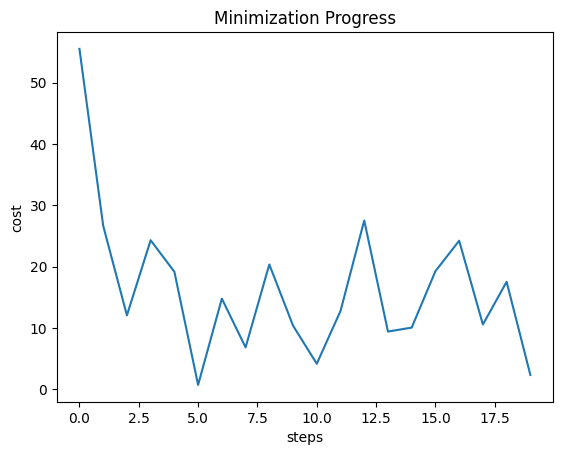

In [33]:
plt.title("Minimization Progress")
plt.plot(list(range(len(history))), history)
plt.xlabel("steps")
plt.ylabel("cost")
plt.savefig("cost-history-qaoa.png", bbox_inches="tight")
plt.show()

In [43]:
params = list(result.x)
print("Result values: ", params)

with open("qaoa-parameters.json", "w") as file:
    print("saving results...")
    json.dump(params, file)

print("Assigning parameters...")
answer_qc = isa_qc.assign_parameters(params)

Result values:  [np.float64(1.4077966193920315), np.float64(1.4440693519206949)]
saving results...
Assigning parameters...


In [44]:
sampler = SamplerV2()
job = sampler.run([answer_qc], shots=1000)
bit_strings = job.result()[0].data.meas.get_counts()

Best solution:  0001101001100000


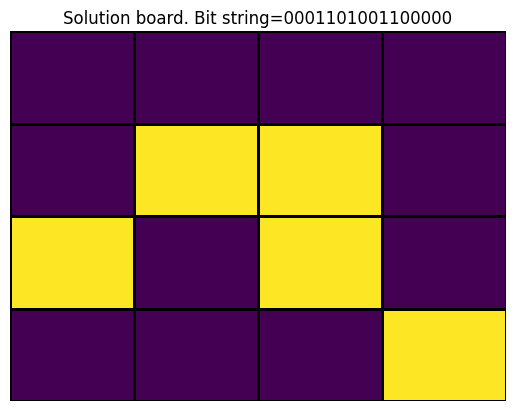

In [46]:
best_solution = max(bit_strings.items(), key=lambda x: x[-1])[0]
print("Best solution: ", best_solution)
solution_board(best_solution,N)